In [1]:
import duckdb
import numpy as np
import pandas as pd
import pyspark
from pyspark.shell import spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import ArrayType, FloatType, DecimalType, StringType, IntegerType
from pyspark.sql.functions import size
from pyspark.storagelevel import StorageLevel
from pyspark import SparkContext
from pyspark.sql.functions import col,when
from pyspark.sql import SparkSession
from pyspark.pandas.spark import functions as SF

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/23 12:46:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.2.0
      /_/

Using Python version 3.9.7 (default, Oct 10 2021 15:08:54)
Spark context Web UI available at http://3fb05e2fcdf0:4040
Spark context available as 'sc' (master = local[*], app id = local-1648039617091).
SparkSession available as 'spark'.


#### Connect to database and get all CSVs in one table

In [2]:
con = duckdb.connect(database=':memory:')

In [325]:
con.execute('''DROP TABLE train''')

In [3]:
con.execute('''
CREATE TABLE train(num INT, tconst VARCHAR, primaryTitle VARCHAR, originalTitle VARCHAR, startYear varchar,
endYear varchar, runtimeMinutes VARCHAR, numVotes FLOAT, label BOOL);
''')

In [11]:
#With copy the CSVs are appended to one table
#This was run 8 times
con.execute('''
COPY train FROM 'train-8.csv' (AUTO_DETECT TRUE)
''')

In [12]:
con.execute(''' SELECT * FROM train''').fetch_df()

,num,tconst,primarytitle,originaltitle,startyear,endyear,runtimeminutes,numvotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True
...,...,...,...,...,...,...,...,...,...
7954,9966,tt9625664,Trauma Center,NaN,2019,\N,87,12951.0,False
7955,9981,tt9741310,Slaxx,Slaxx,2020,\N,77,2464.0,False
7956,9982,tt9742392,Kindred,Kindred,2020,\N,101,1719.0,False
7957,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,NaN,2020,\N,111,4144.0,True


Get the JSONs into different tables

In [13]:
jsonStr = 'writing.json'
# Convert JSON to DataFrame Using read_json()
df = pd.read_json(jsonStr)
con.execute("CREATE TABLE writing AS SELECT * FROM 'df'");

In [14]:
con.execute("SELECT * FROM writing").fetchdf()

,movie,writer
0,tt0003740,nm0195339
1,tt0003740,nm0515385
2,tt0003740,nm0665163
3,tt0003740,nm0758215
4,tt0008663,nm0406585
...,...,...
22423,tt9904802,nm0942647
22424,tt9904802,nm3853396
22425,tt9911196,nm2063122
22426,tt9911196,nm0277932


In [15]:
jsonStr2 = 'directing.json'
# Convert JSON to DataFrame Using read_json()
df2 = pd.read_json(jsonStr2)
con.execute("CREATE TABLE directing AS SELECT * FROM 'df2'");

In [16]:
con.execute("SELECT * FROM directing").fetchdf()

,movie,director
0,tt0003740,nm0665163
1,tt0008663,nm0803705
2,tt0009369,nm0428059
3,tt0009369,nm0949648
4,tt0010307,nm0304098
...,...,...
11157,tt9850344,nm0284774
11158,tt9850386,nm0550881
11159,tt9900782,nm7992231
11160,tt9904802,nm0052054


In [17]:
con.execute("CREATE TABLE test_hidden AS SELECT * FROM 'test_hidden.csv'");
con.execute("SELECT * FROM test_hidden").fetchdf()

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes
0,22,tt0014972,He Who Gets Slapped,He Who Gets Slapped,1924,\N,95,3654.0
1,23,tt0015016,The Iron Horse,NaN,1924,\N,150,2136.0
2,26,tt0015174,Die Nibelungen: Kriemhild's Revenge,NaN,1924,\N,129,4341.0
3,28,tt0015214,At 3:25,NaN,\N,1925,59,1724.0
4,34,tt0015863,Go West,NaN,1925,\N,69,4188.0
...,...,...,...,...,...,...,...,...
1081,9942,tt9430698,One Piece: Stampede,NaN,2019,\N,101,5109.0
1082,9943,tt9441638,The Big Ugly,NaN,2020,\N,106,5780.0
1083,9948,tt9495690,Págálpánti,Pagalpanti,2019,\N,149,2331.0
1084,9950,tt9519642,The Wedding Unplanner,NaN,2020,\N,110,NaN


In [18]:
con.execute("CREATE TABLE validation_hidden AS SELECT * FROM 'validation_hidden.csv'");
con.execute("SELECT * FROM validation_hidden").fetchdf()

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes
0,0,tt0003740,Cabiria,NaN,1914,\N,148,3452.0
1,1,tt0008663,A Man There Was,Terje Vigen,1917,\N,65,1882.0
2,3,tt0010307,J'accuse!,NaN,1919,\N,166,1692.0
3,18,tt0014429,Safety Last!,Safety Last!,1923,\N,74,19898.0
4,27,tt0015175,Die Nibelungen: Siegfried,NaN,1924,\N,143,5676.0
...,...,...,...,...,...,...,...,...
950,9974,tt9686154,You Will Die at 20,NaN,2019,\N,103,2106.0
951,9976,tt9690328,Pápér Spidérs,Paper Spiders,2020,\N,109,NaN
952,9980,tt9735790,Me You Madness,Me You Madness,2021,\N,98,1056.0
953,9984,tt9769668,Tughlaq Durbar,Tughlaq Durbar,2021,\N,145,1430.0


#### From DB to Spark Df and begin preprocessing

In [19]:
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("IMDB") \
    .getOrCreate()

In [20]:
train_df=spark.createDataFrame(con.execute("SELECT * FROM train").fetchdf().where(pd.notnull(con.execute("SELECT * FROM train").fetchdf()),
                                                                                  None))

In [20]:
train_df.show()

+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|       originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|  4|tt0010600|            The Doll|           Die Puppe|     1919|     \N|            66|  1898.0| true|
|  7|tt0011841|       Way Down East|       Way Down East|     1920|     \N|           145|  5376.0| true|
|  9|tt0012494|             Déstiny|        Der müde Tod|     1921|     \N|            97|  5842.0| true|
| 25|tt0015163|       The Navigator|       The Navigator|     1924|     \N|            59|  9652.0| true|
| 38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|     \N|            93| 17887.0| true|
| 42|tt0016630|     Báttling Bútlér|     Battling Butler|     1926|     \N|            77|  3285.0| true|
| 81|tt0021015|Juno and the Paycock|          

In [21]:
train_df.printSchema()

root
 |-- num: long (nullable = true)
 |-- tconst: string (nullable = true)
 |-- primarytitle: string (nullable = true)
 |-- originaltitle: string (nullable = true)
 |-- startyear: string (nullable = true)
 |-- endyear: string (nullable = true)
 |-- runtimeminutes: string (nullable = true)
 |-- numvotes: double (nullable = true)
 |-- label: boolean (nullable = true)



Check for duplicates - There are none

In [136]:
directors_df = directors_df.dropDuplicates(['movie'])
#train_df.show()

In [137]:
directors_df.count()

10000

##### Drop rows that have null values in runtimeminutes/numvotes

In [22]:
train_df = train_df.dropna(subset=["runtimeminutes","numvotes"])
train_df.show()

+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|       originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|  4|tt0010600|            The Doll|           Die Puppe|     1919|     \N|            66|  1898.0| true|
|  7|tt0011841|       Way Down East|       Way Down East|     1920|     \N|           145|  5376.0| true|
|  9|tt0012494|             Déstiny|        Der müde Tod|     1921|     \N|            97|  5842.0| true|
| 25|tt0015163|       The Navigator|       The Navigator|     1924|     \N|            59|  9652.0| true|
| 38|tt0016220|The Phantom of th...|The Phantom of th...|     1925|     \N|            93| 17887.0| true|
| 42|tt0016630|     Báttling Bútlér|     Battling Butler|     1926|     \N|            77|  3285.0| true|
| 81|tt0021015|Juno and the Paycock|          

##### Add YearSinceRealease feature

In [23]:
from pyspark.sql.functions import when

Replace \N with 2022 in endyear

In [24]:
train_df = train_df.withColumn("endyear", when(train_df.endyear == "\\N","2022")
                                 .otherwise(train_df.endyear))

Swap start and endyear where necesseary

In [25]:
train_df = train_df.withColumn("startyear", when(train_df.startyear == "\\N", train_df.endyear)
                              .otherwise(train_df.startyear))

In [26]:
train_df = train_df.withColumn("endyear", when(train_df.endyear == train_df.startyear, "2022")
                              .otherwise(train_df.endyear))

Check if it was done correctly

In [86]:
test1 = train_df.filter(train_df.primarytitle == "The Philadelphia Story")
test1.show()

+---+---------+--------------------+-------------+---------+-------+--------------+--------+-----+
|num|   tconst|        primarytitle|originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+--------------------+-------------+---------+-------+--------------+--------+-----+
|272|tt0032904|The Philadelphia ...|         null|     1940|   2022|           112| 66874.0| true|
+---+---------+--------------------+-------------+---------+-------+--------------+--------+-----+



In [87]:
test2 = train_df.filter(train_df.primarytitle == "The Thief of Bagdad")
test2.show()

+---+---------+-------------------+-------------+---------+-------+--------------+--------+-----+
|num|   tconst|       primarytitle|originaltitle|startyear|endyear|runtimeminutes|numvotes|label|
+---+---------+-------------------+-------------+---------+-------+--------------+--------+-----+
| 31|tt0015400|The Thief of Bagdad|         null|     1924|   2022|           155|  6001.0| true|
|279|tt0033152|The Thief of Bagdad|         null|     1940|   2022|           106| 12840.0| true|
+---+---------+-------------------+-------------+---------+-------+--------------+--------+-----+



#### It works!

New feature: YearSinceRelease

In [27]:
train_df = train_df.withColumn('YearSinceRealease', ( train_df['endyear'] - train_df['startyear'] ))

Check how many rows have \N in runtimeminutes column

In [28]:
print(train_df.where(train_df.runtimeminutes == '\\N').count())

12


In [28]:
#They are few, so we can drop them
train_df=train_df.where(train_df.runtimeminutes != '\\N')

In [91]:
train_df.show()

+---+---------+--------------------+-----------------+---------+-------+--------------+--------+-----+-----------------+
|num|   tconst|        primarytitle|    originaltitle|startyear|endyear|runtimeminutes|numvotes|label|YearSinceRealease|
+---+---------+--------------------+-----------------+---------+-------+--------------+--------+-----+-----------------+
|  2|tt0009369|              Mickey|           Mickey|     1918|   2022|            93|  1119.0|false|            104.0|
|  4|tt0010600|            The Doll|        Die Puppe|     1919|   2022|            66|  1898.0| true|            103.0|
|  5|tt0011439|   The Mark of Zorro|The Mark of Zorro|     1920|   2022|            79|  2439.0| true|            102.0|
|  6|tt0011607|  The Parson's Widow|       Prästänkan|     1920|   2022|            94|  1264.0| true|            102.0|
|  7|tt0011841|       Way Down East|    Way Down East|     1920|   2022|           145|  5376.0| true|            102.0|
|  8|tt0012349|             The 

In [214]:
train_df.printSchema()

root
 |-- num: long (nullable = true)
 |-- tconst: string (nullable = true)
 |-- primarytitle: string (nullable = true)
 |-- originaltitle: string (nullable = true)
 |-- startyear: string (nullable = true)
 |-- endyear: string (nullable = true)
 |-- runtimeminutes: string (nullable = true)
 |-- numvotes: double (nullable = true)
 |-- label: boolean (nullable = true)
 |-- YearSinceRealease: double (nullable = true)



#### Additional data

In [29]:
con.execute('''
CREATE TABLE additional_data AS SELECT * FROM 'movies_info.csv';
''')

In [30]:
con.execute('''
SELECT * FROM additional_data''').fetch_df()

,imdb_id,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list
0,tt0010600,False,NaN,0.0,48256.0,de,Die Puppe,The misadventures of an effete young man who m...,4.861,"[{'id': 12950, 'logo_path': None, 'name': 'Pro...",...,66.0,NaN,The Doll,False,7.3,60.0,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],[]
1,tt0011841,False,NaN,0.0,31509.0,en,Way Down East,A naive country girl is tricked into a sham ma...,7.617,"[{'id': 4759, 'logo_path': None, 'name': 'D.W....",...,145.0,A simple story for plain people.,Way Down East,False,7.0,70.0,"['Drama', 'Action', 'Romance']","['D.W. Griffith Productions', 'United Artists']",['US'],[]
2,tt0012494,False,NaN,0.0,29267.0,de,Der müde Tod,As a young couple stops and rests in a small v...,7.593,"[{'id': 6762, 'logo_path': None, 'name': 'Decl...",...,105.0,Love is Stronger Than Death,Destiny,False,7.5,107.0,"['Drama', 'Fantasy', 'Thriller']",['Decla-Bioscop'],['DE'],['de']
3,tt0015163,False,NaN,0.0,32318.0,en,The Navigator,The wealthy and impulsive Rollo Treadway decid...,7.881,"[{'id': 12190, 'logo_path': None, 'name': 'Bus...",...,65.0,"Hurry! Hurry! Throw out the ""laff"" line!",The Navigator,False,7.3,152.0,"['Action', 'Comedy', 'Romance']",['Buster Keaton Productions'],['US'],[]
4,tt0016220,False,NaN,0.0,964.0,en,The Phantom of the Opera,"A grotesquely disfigured composer known as ""Th...",12.830,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...",...,101.0,The greatest horror film of modern cinema!,The Phantom of the Opera,False,7.2,243.0,"['Drama', 'Horror']",['Universal Pictures'],['US'],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7919,tt9625664,False,NaN,0.0,641790.0,en,Trauma Center,Lt. Wakes is a vengeful police detective deter...,21.290,"[{'id': 121204, 'logo_path': None, 'name': 'Bo...",...,87.0,The enemy is closer than you think,Trauma Center,False,5.7,310.0,"['Action', 'Thriller']","['BondIt Media Capital', 'Buffalo 8', 'Pimient...",['US'],"['en', 'es']"
7920,tt9741310,False,NaN,0.0,605133.0,en,Slaxx,When a possessed pair of jeans begins to kill ...,7.712,"[{'id': 62055, 'logo_path': None, 'name': 'EMA...",...,77.0,An ass to die for.,Slaxx,False,5.8,98.0,"['Comedy', 'Horror']","['EMAfilms', 'Entertainment Squad']",['CA'],"['en', 'hi']"
7921,tt9742392,False,NaN,0.0,717672.0,en,Kindred,When her boyfriend Ben suddenly dies in an acc...,5.826,"[{'id': 137874, 'logo_path': None, 'name': 'Re...",...,101.0,Family is everything.,Kindred,False,5.9,11.0,"['Drama', 'Mystery', 'Horror', 'Thriller']","['Reiver Pictures', 'IFC Midnight', 'Head Gear...",['GB'],['en']
7922,tt9850386,False,NaN,0.0,730009.0,en,The Bee Gees: How Can You Mend a Broken Heart,The story of the triumphs and hurdles of broth...,9.072,"[{'id': 862, 'logo_path': '/udTjbqPmcTbfrihMuL...",...,111.0,NaN,The Bee Gees: How Can You Mend a Broken Heart,False,8.0,37.0,"['Music', 'Documentary']","['The Kennedy/Marshall Company', 'White Horse ...",['US'],['en']


In [31]:
con.execute('''
SELECT  CAST(imdb_id AS VARCHAR) AS 'imdb_id'
FROM    additional_data
''').fetch_df()

,imdb_id
0,tt0010600
1,tt0011841
2,tt0012494
3,tt0015163
4,tt0016220
...,...
7919,tt9625664
7920,tt9741310
7921,tt9742392
7922,tt9850386


In [32]:
moredata_df=spark.createDataFrame(con.execute("SELECT * FROM additional_data").fetchdf().where(pd.notnull(con.execute("SELECT * FROM additional_data").fetchdf()),
                                                                                  None))

In [201]:
moredata_df.count()

7924

In [202]:
moredata_df.show()

+---------+-----+---------------------+--------+-------+-----------------+--------------------+--------------------+------------------+--------------------+-------------------+---------+-------+--------------------+--------------------+-----+------------+----------+--------------------+--------------------+----------------------+--------------------+
|  imdb_id|adult|belongs_to_collection|  budget|     id|original_language|      original_title|            overview|        popularity|production_companies|       release_date|  revenue|runtime|             tagline|               title|video|vote_average|vote_count|          genre_list|     production_list|production_countr_list|spoken_language_list|
+---------+-----+---------------------+--------+-------+-----------------+--------------------+--------------------+------------------+--------------------+-------------------+---------+-------+--------------------+--------------------+-----+------------+----------+--------------------+-------

In [215]:
moredata_df.printSchema()

root
 |-- imdb_id: string (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- id: double (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- revenue: double (nullable = true)
 |-- runtime: double (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: double (nullable = true)
 |-- genre_list: string (nullable = true)
 |-- production_list: string (nullable = true)
 |-- production_countr_list: string (nullable = true)
 |-- spoken_language_list: string (nullable = true)



In [33]:
writers_df=spark.createDataFrame(con.execute("SELECT * FROM writing").fetchdf().where(pd.notnull(con.execute("SELECT * FROM writing").fetchdf()),
                                                                                  None))

In [34]:
directors_df=spark.createDataFrame(con.execute("SELECT * FROM directing").fetchdf().where(pd.notnull(con.execute("SELECT * FROM directing").fetchdf()),
                                                                                  None))

In [35]:
test_hidden_df=spark.createDataFrame(con.execute("SELECT * FROM test_hidden").fetchdf().where(pd.notnull(con.execute("SELECT * FROM test_hidden").fetchdf()),
                                                                                  None))

In [36]:
validation_hidden_df=spark.createDataFrame(con.execute("SELECT * FROM validation_hidden").fetchdf().where(pd.notnull(con.execute("SELECT * FROM validation_hidden").fetchdf()),
                                                                                  None))

In [41]:
writers_df.show()

+---------+---------+
|    movie|   writer|
+---------+---------+
|tt0003740|nm0195339|
|tt0003740|nm0515385|
|tt0003740|nm0665163|
|tt0003740|nm0758215|
|tt0008663|nm0406585|
|tt0008663|nm0596410|
|tt0008663|nm0803705|
|tt0009369|nm0215874|
|tt0009369|nm0370271|
|tt0010307|nm0304098|
|tt0010600|nm0006782|
|tt0010600|nm0473134|
|tt0010600|nm0523932|
|tt0010600|nm0932559|
|tt0011439|nm0191547|
|tt0011439|nm0001196|
|tt0011439|nm1491939|
|tt0011607|nm0003433|
|tt0011607|nm0418114|
|tt0011841|nm0662461|
+---------+---------+
only showing top 20 rows



In [37]:
from pyspark.sql.functions import collect_list
grouped_writers = writers_df.groupby('movie').agg(collect_list('writer').alias("writers"))

In [134]:
grouped_writers.show()

+---------+--------------------+
|    movie|             writers|
+---------+--------------------+
|tt0003740|[nm0195339, nm051...|
|tt0008663|[nm0406585, nm059...|
|tt0009369|[nm0215874, nm037...|
|tt0010307|         [nm0304098]|
|tt0010600|[nm0006782, nm047...|
|tt0011439|[nm0191547, nm000...|
|tt0011607|[nm0003433, nm041...|
|tt0011841|[nm0662461, nm010...|
|tt0012349|         [nm0000122]|
|tt0012494|[nm0000485, nm090...|
|tt0012532|[nm0257866, nm018...|
|tt0013257|         [nm0159725]|
|tt0013556|[nm0001196, nm020...|
|tt0013933|[nm0258477, nm025...|
|tt0014109|[nm0405147, nm048...|
|tt0014142|[nm0401076, nm079...|
|tt0014341|[nm0369841, nm011...|
|tt0014358|         [nm0000122]|
|tt0014429|[nm0730018, nm085...|
|tt0014538|[nm0115669, nm059...|
+---------+--------------------+
only showing top 20 rows



In [154]:
directors_df.show()

+---------+---------+
|    movie| director|
+---------+---------+
|tt0003740|nm0665163|
|tt0008663|nm0803705|
|tt0009369|nm0428059|
|tt0009369|nm0949648|
|tt0010307|nm0304098|
|tt0010600|nm0523932|
|tt0011439|nm0629243|
|tt0011607|nm0003433|
|tt0011841|nm0000428|
|tt0012349|nm0000122|
|tt0012494|nm0000485|
|tt0012532|nm0000428|
|tt0013257|nm0159725|
|tt0013556|nm0245385|
|tt0013933|nm0258477|
|tt0014109|nm0830249|
|tt0014142|nm0941637|
|tt0014341|nm0090007|
|tt0014341|nm0000036|
|tt0014358|nm0000122|
+---------+---------+
only showing top 20 rows



##### Merge all dataframe togerther (inito_numpy writers, directors, extra data)

Issues with merging - not anymore!

In [38]:
from pyspark.sql.functions import monotonically_increasing_id
#train_df = train_df.withColumn("tconst",monotonically_increasing_id() )
#customers_df.show()
#moredata_df = moredata_df.withColumn( "imdb_id", monotonically_increasing_id() )
#orders_df.show()
horiztnlcombined_data = train_df.join(moredata_df, train_df.tconst == moredata_df.imdb_id, 'inner')
horiztnlcombined_data.count()
# Now it seems to work

7128

In [217]:
horiztnlcombined_data.toPandas()
#It seems to work

,num,tconst,primarytitle,originaltitle,startyear,endyear,runtimeminutes,numvotes,label,YearSinceRealease,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list
0,428,tt0039305,Dead Reckoning,None,1947,2022,100,7368.0,True,75.0,...,100.0,He Doesn't Trust Anyone... Especially Women!,Dead Reckoning,False,6.7,100.0,"['Thriller', 'Crime', 'Drama', 'Mystery']",['Columbia Pictures'],['US'],['en']
1,6698,tt1582271,The Good Doctor,None,2011,2022,91,6698.0,False,11.0,...,93.0,Do no harm.,The Good Doctor,False,6.2,185.0,"['Drama', 'Thriller', 'Mystery']","['Viddywell', 'Code Red']",['US'],"['en', 'es']"
2,9213,tt6176928,Whớsé Strééts?,None,2017,2022,102,1329.0,False,5.0,...,90.0,None,Whose Streets?,False,5.8,19.0,['Documentary'],"['Magnolia Pictures', 'JustFilms / Ford Founda...",['US'],['en']
3,9715,tt8235296,The Trump Prophecy,None,2018,2022,120,2302.0,False,4.0,...,120.0,One man's journey to find healing.,The Trump Prophecy,False,4.0,7.0,['Drama'],['ReelWorks Studios'],['US'],['en']
4,1600,tt0074478,Émánúéllé in Bángkớk,None,1976,2022,92,1045.0,False,46.0,...,87.0,She's Hotter Than Ever!,Emanuelle in Bangkok,False,4.5,34.0,"['Drama', 'Romance', 'Adventure']","['San Nicola Produzione Cinematografica', 'Fla...",['IT'],['it']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,1029,tt0058458,The Soft Skin,La peau douce,1964,2022,113,7415.0,True,58.0,...,119.0,The Eternal Triangle At Its Most Eternal,The Soft Skin,False,7.2,143.0,"['Drama', 'Romance']","['Les Films du Carrosse', ""Societé d'Exploitat...",['FR'],"['en', 'fr', 'pt']"
7124,4093,tt0281718,Friend,Chingoo,2001,2022,113,4932.0,True,21.0,...,118.0,None,Friend,False,6.8,61.0,"['Action', 'Drama']",['Cineline 2'],['KR'],['ko']
7125,4916,tt0443584,Mélissá P.,Melissa P.,2005,2022,100,6463.0,False,17.0,...,100.0,You have to lose yourself before you can find ...,Melissa P.,False,4.3,463.0,['Drama'],"['Pentagrama Films', 'Bess Movie']","['IT', 'ES']",['it']
7126,9706,tt8178486,Earthquake Bird,None,2019,2022,107,13895.0,False,3.0,...,107.0,Look beyond what you see,Earthquake Bird,False,5.9,335.0,"['Drama', 'Mystery', 'Romance', 'Thriller']","['Scott Free Productions', 'Twenty First City']","['JP', 'GB']","['en', 'ja']"


In [39]:
directors_df = directors_df.selectExpr("movie as movie_d","director as director")
writers_directors = grouped_writers.join(directors_df, grouped_writers.movie == directors_df.movie_d, 'inner')

In [179]:
writers_directors.show()

+---------+--------------------+---------+---------+
|    movie|             writers|  movie_d| director|
+---------+--------------------+---------+---------+
|tt0018526|[nm0299153, nm000...|tt0018526|nm0903049|
|tt0018526|[nm0299153, nm000...|tt0018526|nm0744504|
|tt0039305|[nm0308177, nm027...|tt0039305|nm0188669|
|tt0044008|[nm0002042, nm048...|tt0044008|nm0221423|
|tt0054152|         [nm0001294]|tt0054152|nm0715346|
|tt0054412|         [nm0447860]|tt0054412|nm0623768|
|tt0037101|[nm0668122, nm015...|tt0037101|nm0229424|
|tt0041859|[nm0169883, nm054...|tt0041859|nm0936404|
|tt0054745|                [\N]|tt0054745|nm0602841|
|tt0054745|                [\N]|tt0054745|nm0745541|
|tt0030643|[nm0241409, nm069...|tt0030643|nm0138893|
|tt0041716|[nm0337582, nm017...|tt0041716|nm0002045|
|tt0041716|[nm0337582, nm017...|tt0041716|nm0000037|
|tt0043918|[nm0345363, nm024...|tt0043918|nm0245213|
|tt0048682|         [nm0827666]|tt0048682|nm0000339|
|tt0048933|[nm0621534, nm079...|tt0048933|nm00

Problem with the final merge - different schemas between the two dataframes

In [218]:
horiztnlcombined_data.printSchema()

root
 |-- num: long (nullable = true)
 |-- tconst: string (nullable = true)
 |-- primarytitle: string (nullable = true)
 |-- originaltitle: string (nullable = true)
 |-- startyear: string (nullable = true)
 |-- endyear: string (nullable = true)
 |-- runtimeminutes: string (nullable = true)
 |-- numvotes: double (nullable = true)
 |-- label: boolean (nullable = true)
 |-- YearSinceRealease: double (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- adult: boolean (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- id: double (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- release_date: timestamp (nullable = true)
 |-- revenue: double (nullable = true)
 |-- runtime: double (nullable = true)
 |-- tagline: string (null

In [219]:
writers_directors.printSchema()

root
 |-- movie: string (nullable = true)
 |-- writers: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- movie_d: string (nullable = true)
 |-- director: string (nullable = true)



In [187]:
writers_directors.show()

+---------+--------------------+---------+---------+
|    movie|             writers|  movie_d| director|
+---------+--------------------+---------+---------+
|tt0018526|[nm0299153, nm000...|tt0018526|nm0903049|
|tt0018526|[nm0299153, nm000...|tt0018526|nm0744504|
|tt0039305|[nm0308177, nm027...|tt0039305|nm0188669|
|tt0044008|[nm0002042, nm048...|tt0044008|nm0221423|
|tt0054152|         [nm0001294]|tt0054152|nm0715346|
|tt0054412|         [nm0447860]|tt0054412|nm0623768|
|tt0037101|[nm0668122, nm015...|tt0037101|nm0229424|
|tt0041859|[nm0169883, nm054...|tt0041859|nm0936404|
|tt0054745|                [\N]|tt0054745|nm0602841|
|tt0054745|                [\N]|tt0054745|nm0745541|
|tt0030643|[nm0241409, nm069...|tt0030643|nm0138893|
|tt0041716|[nm0337582, nm017...|tt0041716|nm0002045|
|tt0041716|[nm0337582, nm017...|tt0041716|nm0000037|
|tt0043918|[nm0345363, nm024...|tt0043918|nm0245213|
|tt0048682|         [nm0827666]|tt0048682|nm0000339|
|tt0048933|[nm0621534, nm079...|tt0048933|nm00

In [49]:
final_df = horiztnlcombined_data.join(writers_directors, horiztnlcombined_data.tconst == writers_directors.movie, 'inner')

In [226]:
final_df.toPandas()

,num,tconst,primarytitle,originaltitle,startyear,endyear,runtimeminutes,numvotes,label,YearSinceRealease,...,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list,movie,writers,movie_d,director
0,4,tt0010600,The Doll,Die Puppe,1919,2022,66,1898.0,True,103.0,...,7.3,60.0,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],[],tt0010600,"[nm0006782, nm0473134, nm0523932, nm0932559]",tt0010600,nm0523932
1,8,tt0012349,The Kid,None,1921,2022,68,121452.0,True,101.0,...,8.2,1536.0,"['Comedy', 'Drama']",['Charles Chaplin Productions'],['US'],[],tt0012349,[nm0000122],tt0012349,nm0000122
2,9,tt0012494,Déstiny,Der müde Tod,1921,2022,97,5842.0,True,101.0,...,7.5,107.0,"['Drama', 'Fantasy', 'Thriller']",['Decla-Bioscop'],['DE'],['de'],tt0012494,"[nm0000485, nm0902376]",tt0012494,nm0000485
3,31,tt0015400,The Thief of Bagdad,None,1924,2022,155,6001.0,True,98.0,...,7.4,101.0,"['Romance', 'Adventure', 'Fantasy']",['Douglas Fairbanks Pictures'],['US'],[],tt0015400,"[nm0940689, nm0001196, nm0008280, nm0640884]",tt0015400,nm0909825
4,37,tt0016029,The Little Colonel,None,1935,2022,81,1646.0,True,87.0,...,6.6,21.0,"['Comedy', 'Family', 'Music']",['Fox Film Corporation'],['US'],['en'],tt0016029,"[nm0175902, nm0426531, nm0124877]",tt0016029,nm0124877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,9958,tt9586294,Better Days,None,2019,2022,135,8011.0,True,3.0,...,8.4,223.0,['Drama'],"['Shooting Pictures', 'China Wit Media', 'Tian...","['CN', 'HK']",['zh'],tt9586294,"[nm5528735, nm8430396, nm7163521, nm11642416, ...",tt9586294,nm1229124
7986,9969,tt9652782,Bait,Bait,2019,2022,89,4356.0,True,3.0,...,7.1,55.0,['Drama'],['Early Day Films'],['GB'],['en'],tt9652782,[nm1985490],tt9652782,nm1985490
7987,9977,tt9691136,Shadow in the Cloud,None,2020,2022,83,22617.0,False,2.0,...,5.8,550.0,"['Horror', 'Action', 'War']","['Four Knights Film', 'Rhea Films', 'Automatik...","['NZ', 'US']",['en'],tt9691136,"[nm0484840, nm1755396]",tt9691136,nm1755396
7988,9982,tt9742392,Kindred,Kindred,2020,2022,101,1719.0,False,2.0,...,5.9,11.0,"['Drama', 'Mystery', 'Horror', 'Thriller']","['Reiver Pictures', 'IFC Midnight', 'Head Gear...",['GB'],['en'],tt9742392,"[nm2660375, nm3553292]",tt9742392,nm2660375


Keep useful columns

In [50]:
cols = ('num', 'tconst', 'primarytitle', 'originaltitle', 'endyear', 'imdb_id', 'belongs_to_collection', 
        'budget', 'id', 'original_title', 'overview', 'production_companies',
         'release_date', 'revenue', 'runtime', 'tagline', 'title', 'video', 'vote_count', 'spoken_language_list',  'movie', 'movie_d')
final_df = final_df.drop(*cols)
#final_df.show()

In [228]:
final_df.toPandas()

,startyear,runtimeminutes,numvotes,YearSinceRealease,adult,original_language,popularity,vote_average,genre_list,production_list,production_countr_list,writers,director
0,1918,93,1119.0,104.0,False,en,1.926,6.7,"['Comedy', 'Drama']",['Mabel Normand Feature Film Company'],['US'],"[nm0215874, nm0370271]",nm0949648
1,1918,93,1119.0,104.0,False,en,1.926,6.7,"['Comedy', 'Drama']",['Mabel Normand Feature Film Company'],['US'],"[nm0215874, nm0370271]",nm0428059
2,1919,66,1898.0,103.0,False,de,4.861,7.3,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],"[nm0006782, nm0473134, nm0523932, nm0932559]",nm0523932
3,1920,79,2439.0,102.0,False,en,6.518,7.3,"['Western', 'Adventure', 'Drama', 'Action', 'R...",['Douglas Fairbanks Pictures'],['US'],"[nm0191547, nm0001196, nm1491939]",nm0629243
4,1920,94,1264.0,102.0,False,sv,1.970,7.5,"['Comedy', 'Drama']",['SF Studios'],['SE'],"[nm0003433, nm0418114]",nm0003433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,2019,89,3568.0,3.0,False,en,24.337,6.9,"['Comedy', 'Horror', 'Science Fiction', 'Thril...",['Blue Ribbon Content'],['US'],"[nm0253624, nm1698584]",nm0261629
7986,2019,99,2451.0,3.0,False,fr,6.425,7.1,"['Drama', 'Romance']","['Paprika Films', 'Tarantula', 'Artémis Produc...","['BE', 'FR', 'LU']","[nm11042781, nm2889273, nm0897095]",nm2889273
7987,2020,98,1325.0,2.0,False,fr,10.303,5.5,['Drama'],"['F Comme Film', 'Ciné@', 'StudioCanal']",['FR'],"[nm3124777, nm1987983, nm0284774]",nm0284774
7988,2020,111,4144.0,2.0,False,en,9.072,8.0,"['Music', 'Documentary']","['The Kennedy/Marshall Company', 'White Horse ...",['US'],[nm0598531],nm0550881


##### Encoding

Trying to encode with One Hot Encoder for spark dataframe

In [119]:
#   ##  import the required libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

  ##  numeric indexing for the strings (indexing starts from 0)
indexer = StringIndexer(inputCol="genre_list", outputCol="GenreNumericIndex")

  ##  fit the indexer model and use it to transform the strings into numeric indices
final_df = indexer.fit(final_df).transform(final_df)

  ##  one-hot-encoding the numeric indices
ohe = OneHotEncoder(inputCol="GenreNumericIndex", outputCol="GenreOHEVector")

  ##  fit the ohe model and use it to transform the numeric indices into ohe vectors
final_df = ohe.fit(final_df).transform(final_df)

#final_df.show()
#   ##  get datatype of the ohe vector column
print(final_df.schema["GenreOHEVector"].dataType)

VectorUDT


Convert it to pandas dataframe in order to feed it to the model

In [51]:
final_pandas = final_df.toPandas()

In [230]:
final_pandas

,startyear,runtimeminutes,numvotes,YearSinceRealease,adult,original_language,popularity,vote_average,genre_list,production_list,production_countr_list,writers,director
0,1918,93,1119.0,104.0,False,en,1.926,6.7,"['Comedy', 'Drama']",['Mabel Normand Feature Film Company'],['US'],"[nm0215874, nm0370271]",nm0949648
1,1918,93,1119.0,104.0,False,en,1.926,6.7,"['Comedy', 'Drama']",['Mabel Normand Feature Film Company'],['US'],"[nm0215874, nm0370271]",nm0428059
2,1919,66,1898.0,103.0,False,de,4.861,7.3,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],"[nm0006782, nm0473134, nm0523932, nm0932559]",nm0523932
3,1920,79,2439.0,102.0,False,en,6.518,7.3,"['Western', 'Adventure', 'Drama', 'Action', 'R...",['Douglas Fairbanks Pictures'],['US'],"[nm0191547, nm0001196, nm1491939]",nm0629243
4,1920,94,1264.0,102.0,False,sv,1.970,7.5,"['Comedy', 'Drama']",['SF Studios'],['SE'],"[nm0003433, nm0418114]",nm0003433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,2019,89,3568.0,3.0,False,en,24.337,6.9,"['Comedy', 'Horror', 'Science Fiction', 'Thril...",['Blue Ribbon Content'],['US'],"[nm0253624, nm1698584]",nm0261629
7986,2019,99,2451.0,3.0,False,fr,6.425,7.1,"['Drama', 'Romance']","['Paprika Films', 'Tarantula', 'Artémis Produc...","['BE', 'FR', 'LU']","[nm11042781, nm2889273, nm0897095]",nm2889273
7987,2020,98,1325.0,2.0,False,fr,10.303,5.5,['Drama'],"['F Comme Film', 'Ciné@', 'StudioCanal']",['FR'],"[nm3124777, nm1987983, nm0284774]",nm0284774
7988,2020,111,4144.0,2.0,False,en,9.072,8.0,"['Music', 'Documentary']","['The Kennedy/Marshall Company', 'White Horse ...",['US'],[nm0598531],nm0550881


#### ML Model 

In [155]:
final_pandas.isnull().sum()

startyear                    0
runtimeminutes               0
numvotes                     0
label                        0
YearSinceRealease            0
adult                     6167
original_language         6167
popularity                6167
vote_average              6167
vote_count                6167
genre_list                6167
production_list           6167
production_countr_list    6167
spoken_language_list      6167
writer                    5109
director                  6133
dtype: int64

In [213]:
pip install lightgbm

     |████████████████████████████████| 2.1 MB 1.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [57]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

##### Create df to feed to the model (should be done in PySpark)

In [36]:
train_pd = train_df.toPandas()
writers_pd = writers_df.toPandas()
directors_pd = directors_df.toPandas()
more_pd = moredata_df.toPandas()

In [117]:
test_pd = test_hidden_df.toPandas()
val_pd = validation_hidden_df.toPandas()

In [40]:
merged1 = train_pd.merge(more_pd, left_on = 'tconst', right_on = 'imdb_id', how = 'inner')

In [41]:
merged1

,num,tconst,primarytitle,originaltitle,startyear,endyear,runtimeminutes,numvotes,label,YearSinceRealease,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list
0,4,tt0010600,The Doll,Die Puppe,1919,2022,66,1898.0,True,103.0,...,66.0,None,The Doll,False,7.3,60.0,"['Comedy', 'Fantasy']",['Projektions-AG Union (PAGU)'],['DE'],[]
1,7,tt0011841,Way Down East,Way Down East,1920,2022,145,5376.0,True,102.0,...,145.0,A simple story for plain people.,Way Down East,False,7.0,70.0,"['Drama', 'Action', 'Romance']","['D.W. Griffith Productions', 'United Artists']",['US'],[]
2,9,tt0012494,Déstiny,Der müde Tod,1921,2022,97,5842.0,True,101.0,...,105.0,Love is Stronger Than Death,Destiny,False,7.5,107.0,"['Drama', 'Fantasy', 'Thriller']",['Decla-Bioscop'],['DE'],['de']
3,25,tt0015163,The Navigator,The Navigator,1924,2022,59,9652.0,True,98.0,...,65.0,"Hurry! Hurry! Throw out the ""laff"" line!",The Navigator,False,7.3,152.0,"['Action', 'Comedy', 'Romance']",['Buster Keaton Productions'],['US'],[]
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,2022,93,17887.0,True,97.0,...,101.0,The greatest horror film of modern cinema!,The Phantom of the Opera,False,7.2,243.0,"['Drama', 'Horror']",['Universal Pictures'],['US'],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,9966,tt9625664,Trauma Center,None,2019,2022,87,12951.0,False,3.0,...,87.0,The enemy is closer than you think,Trauma Center,False,5.7,310.0,"['Action', 'Thriller']","['BondIt Media Capital', 'Buffalo 8', 'Pimient...",['US'],"['en', 'es']"
7124,9981,tt9741310,Slaxx,Slaxx,2020,2022,77,2464.0,False,2.0,...,77.0,An ass to die for.,Slaxx,False,5.8,98.0,"['Comedy', 'Horror']","['EMAfilms', 'Entertainment Squad']",['CA'],"['en', 'hi']"
7125,9982,tt9742392,Kindred,Kindred,2020,2022,101,1719.0,False,2.0,...,101.0,Family is everything.,Kindred,False,5.9,11.0,"['Drama', 'Mystery', 'Horror', 'Thriller']","['Reiver Pictures', 'IFC Midnight', 'Head Gear...",['GB'],['en']
7126,9996,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,None,2020,2022,111,4144.0,True,2.0,...,111.0,None,The Bee Gees: How Can You Mend a Broken Heart,False,8.0,37.0,"['Music', 'Documentary']","['The Kennedy/Marshall Company', 'White Horse ...",['US'],['en']


In [118]:
merged_test = test_pd.merge(more_pd, left_on = 'tconst', right_on = 'imdb_id', how = 'inner')
merged_val = val_pd.merge(more_pd, left_on = 'tconst', right_on = 'imdb_id', how = 'inner')

In [124]:
merged_val

,column0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,imdb_id,adult,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list


##### One hot encoding for features

In [52]:
one_hot_g = pd.DataFrame()
one_hot_g['genres'] = final_pandas['genre_list'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.split(',')
#one_hot_g['genres'] = final_pandas['genre_list'].str.split(',')

In [251]:
one_hot_pr = pd.DataFrame()
one_hot_g['prods'] = final_pandas['production_list'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.split(',')

In [53]:
one_hot_g['genres'] = one_hot_g['genres'].apply(lambda x: set(x))

In [62]:
one_hot_w = pd.DataFrame()
one_hot_w['writers'] = final_pandas['writers'].apply(lambda x: set(x))

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot_df = pd.DataFrame(mlb.fit_transform(one_hot_g['genres']),columns=mlb.classes_)

In [64]:
one_hot_df1 = pd.DataFrame(mlb.fit_transform(one_hot_w['writers']),columns=mlb.classes_)

TODO: Include the directors

In [72]:
one_hot_d = pd.DataFrame()
# Get one hot encoding of columns B
one_hot_d = pd.get_dummies(final_pandas['director'])
# Drop column B as it is now encoded
#df = df.drop('B',axis = 1)
# Join the encoded df
#final_pandas = final_pandas.join(one_hot_d)


In [55]:
final_pandas = final_pandas.join(one_hot_df)

In [65]:
final_pandas = final_pandas.join(one_hot_df1)

In [80]:
#list(final_pandas.columns)

In [58]:
# creating instance of labelencoder
# labelencoder = LabelEncoder()
# # Assigning numerical values and storing in another column
# merged1['startyear_Cat'] = labelencoder.fit_transform(merged1['startyear'])
# merged1['production_countr_list_Cat'] = labelencoder.fit_transform(merged1['production_countr_list'])

In [81]:
        
# To define the input and output feature
# 'num','tconst','primarytitle','originaltitle', 'endyear',
# x = merged1.drop(["num","tconst","primarytitle","originaltitle", "endyear","imdb_id", "belongs_to_collection", "budget",
#         "id", "original_title", "overview", "tagline", "title", "video", "production_companies", "release_date",
#         "revenue", "runtime",'startyear',"adult", "original_language", "genre_list", "production_list", "production_countr_list",
#                        "spoken_language_list","genres_bin","production_bin", "label"],axis=1)

x = final_pandas.drop(["genre_list", "production_list","original_language",
                       'production_countr_list', 'writers', 'director','','\\N', "label"], axis=1)

x['runtimeminutes'] = x['runtimeminutes'].astype(float)
x['startyear'] = x['startyear'].astype(float)
x['adult'] = x['adult'].astype(int)
y = final_pandas['label']
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

##### Make predictions for hidden data

In [119]:
x = merged_test.drop(["num","tconst","primarytitle","originaltitle", "endyear","imdb_id", "belongs_to_collection", "budget",
        "id", "original_title", "overview", "tagline", "title", "video", "production_companies", "release_date",
        "revenue", "runtime",'startyear',"adult", "original_language", "genre_list", "production_list", "production_countr_list",
                       "spoken_language_list","genres_bin","production_bin", "label"],axis=1)
x['runtimeminutes'] = x['runtimeminutes'].astype(float)
#prediction on the test set
y_pred=clf.predict(x)
#rounding the values
y_pred=y_pred.round(0)
#converting from float to integer
y_pred=y_pred.astype(int)

KeyError: "['num', 'primarytitle', 'originaltitle', 'endyear', 'startyear', 'genres_bin', 'production_bin', 'label'] not found in axis"

In [82]:
lgb_params = {

    'boosting_type':'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators':10000,
    'learning_rate':0.3,
    'num_leaves':2840,
    'max_depth':10,
    'min_data_in_leaf': 300,
'lambda_l1': 35,
'lambda_l2': 65,
'min_gain_to_split': 7.394615335964813,
'bagging_fraction': 0.6,
'bagging_freq': 1,
'feature_fraction': 0.3
                } 
d_train=lgb.Dataset(x_train, label=y_train)

#train the model 
clf=lgb.train(lgb_params,d_train) #train the model on 100 epocs


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2716, number of negative: 2637
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 5353, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507379 -> initscore=0.029518
[LightGBM] [Info] Start training from score 0.029518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [85]:
clf.save_model('model_lgbm.txt')
clf.save_model("model_lgbm.json")

In [86]:
#model_lgb = lgb.Booster(model_file='model_lgbm.txt')

In [83]:
#prediction on the test set
y_pred=clf.predict(x_test)
#rounding the values
y_pred=y_pred.round(0)
#converting from float to integer
y_pred=y_pred.astype(int)

In [84]:
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, accuracy_score
#roc_auc_score metric
accuracy_score(y_pred,y_test.values.astype(int))

0.9366704588547592

In [110]:
validation_pd = pd.read_csv('validation_hidden.csv')
test_pd = pd.read_csv('test_hidden.csv')

In [111]:
validation_pd

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes
0,0,tt0003740,Cabiria,NaN,1914,\N,148,3452.0
1,1,tt0008663,A Man There Was,Terje Vigen,1917,\N,65,1882.0
2,3,tt0010307,J'accuse!,NaN,1919,\N,166,1692.0
3,18,tt0014429,Safety Last!,Safety Last!,1923,\N,74,19898.0
4,27,tt0015175,Die Nibelungen: Siegfried,NaN,1924,\N,143,5676.0
...,...,...,...,...,...,...,...,...
950,9974,tt9686154,You Will Die at 20,NaN,2019,\N,103,2106.0
951,9976,tt9690328,Pápér Spidérs,Paper Spiders,2020,\N,109,NaN
952,9980,tt9735790,Me You Madness,Me You Madness,2021,\N,98,1056.0
953,9984,tt9769668,Tughlaq Durbar,Tughlaq Durbar,2021,\N,145,1430.0


In [165]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
final_pandas['startyear_Cat'] = labelencoder.fit_transform(final_pandas['startyear'])
# final_pandas['writers_Cat'] = labelencoder.fit_transform(final_pandas['writer'])
# final_pandas['directors_Cat'] = labelencoder.fit_transform(final_pandas['director'])
final_pandas

,startyear,runtimeminutes,numvotes,label,YearSinceRealease,adult,original_language,popularity,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list,writer,director,startyear_Cat,writers_Cat,directors_Cat
0,1925,93,17887.0,True,97.0,False,en,2.526,3.2,26.0,['Horror'],"['Sigmund Neufeld Productions', 'PRC']",['US'],['en'],nm0195339,nm0665163,7,275,330
1,1925,143,7539.0,True,97.0,False,en,5.176,6.7,31.0,"['Thriller', 'Crime', 'Drama', 'Mystery']",['Warner Bros. Pictures'],['US'],['en'],nm0515385,nm0803705,7,695,389
2,1955,80,3361.0,True,67.0,False,en,24.991,5.9,1190.0,['Comedy'],"['Milestone Entertainment', 'Lionsgate', 'Karz...","['CA', 'US']",['en'],nm0665163,nm0428059,37,875,232
3,1971,86,2054.0,True,51.0,False,en,3.783,7.6,29.0,"['Romance', 'Drama']",['Fox Film Corporation'],['US'],[],nm0758215,nm0949648,53,985,450
4,1989,84,3031.0,False,33.0,None,None,NaN,NaN,NaN,None,None,None,None,nm0406585,nm0304098,71,551,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7152,2016,102,19970.0,False,6.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,98,1268,452
7153,2015,102,1178.0,False,7.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,97,1268,452
7154,2019,98,5066.0,False,3.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,101,1268,452
7155,2017,68,2255.0,False,5.0,None,None,NaN,NaN,NaN,None,None,None,None,None,None,99,1268,452


In [168]:
# To define the input and output feature
# 'num','tconst','primarytitle','originaltitle', 'endyear',
x = final_pandas.drop(['startyear',"adult", "original_language", 
                       "popularity","vote_average", "vote_count", "genre_list", "production_list", "production_countr_list",
                       "spoken_language_list", 'writer','director'],axis=1)
x = x.dropna()
x['runtimeminutes'] = x['runtimeminutes'].astype(float)
y = x['label']
x = x.drop(['label'],axis=1)
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

In [75]:
print('Training accuracy {:.4f}'.format(clf.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(clf.score(x_test,y_test)))

AttributeError: 'Booster' object has no attribute 'score'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

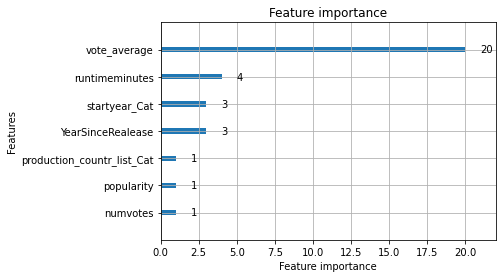

In [78]:
lgb.plot_importance(clf)